In [29]:
import tensorflow as tf 
from tensorflow import keras

print(tf.__version__)
print(keras.__version__)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.test.gpu_device_name())

2.0.0
2.2.4-tf
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15122383843617508641
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3141979340
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17894954920285595147
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
/device:GPU:0


In [30]:
from tensorflow.keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train, y_train = X_train[:2000], y_train[:2000]
X_test, y_test = X_test[:500], y_test[:500]

class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

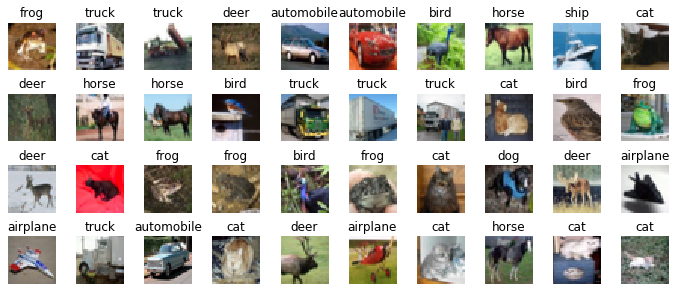

In [31]:
import matplotlib.pyplot as plt

def printImages(images, labels):
    n_rows = 4
    n_cols = 10
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            plt.subplot(n_rows, n_cols, index + 1)
            labels = labels.astype(int)
            labels = labels.reshape(-1)
            plt.imshow(images[index], cmap="binary", interpolation="nearest")
            plt.axis('off')
            plt.title(class_names[labels[index]], fontsize=12)
        plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()

printImages(X_train, y_train)

In [32]:
from sklearn.base import BaseEstimator, TransformerMixin

class Scaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    def fit(self, X):
        return self
    def transform(self, X):
        return X/255.0

scaler = Scaler()

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[32, 32, 3]),
    keras.layers.Dense(1000, activation="relu"),
    keras.layers.Dense(500, activation="relu"),
    keras.layers.Dense(250, activation="relu"),
    keras.layers.Dense(75, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [34]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [35]:
history = model.fit(X_train_scaled, y_train, epochs=30,
                    validation_data=(X_test_scaled, y_test))

Train on 2000 samples, validate on 500 samples
Epoch 1/30
2000/2000 [==============================] - 1s 481us/sample - loss: 2.2123 - accuracy: 0.1835 - val_loss: 2.1489 - val_accuracy: 0.1980
Epoch 2/30
2000/2000 [==============================] - 0s 197us/sample - loss: 2.0674 - accuracy: 0.2520 - val_loss: 2.1330 - val_accuracy: 0.1560
Epoch 3/30
2000/2000 [==============================] - 0s 183us/sample - loss: 1.9632 - accuracy: 0.2780 - val_loss: 2.0473 - val_accuracy: 0.2340
Epoch 4/30
2000/2000 [==============================] - 0s 182us/sample - loss: 1.9120 - accuracy: 0.3105 - val_loss: 2.0518 - val_accuracy: 0.2620
Epoch 5/30
2000/2000 [==============================] - 0s 190us/sample - loss: 1.8573 - accuracy: 0.3340 - val_loss: 2.2075 - val_accuracy: 0.2080
Epoch 6/30
2000/2000 [==============================] - 0s 196us/sample - loss: 1.8278 - accuracy: 0.3495 - val_loss: 2.1087 - val_accuracy: 0.2760
Epoch 7/30
2000/2000 [==============================] - 0s 183us/

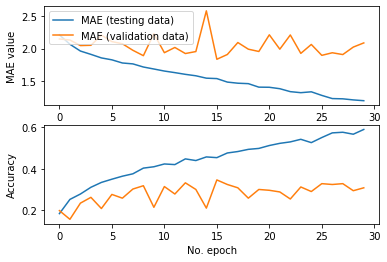

In [36]:
def plotTrainingStat(history):
    fig, ((ax1, ax2)) = plt.subplots(2, 1)

    ax1.plot(history.history['loss'], label='MAE (testing data)')
    ax1.plot(history.history['val_loss'], label='MAE (validation data)')
    ax1.set_ylabel('MAE value')
    ax1.set_xlabel('No. epoch')
    ax1.legend(loc="upper left")

    ax2.plot(history.history['accuracy'], label='MAE (testing data)')
    ax2.plot(history.history['val_accuracy'], label='MAE (validation data)')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('No. epoch')

    fig.show()

plotTrainingStat(history)

In [37]:
from sklearn.cluster import KMeans
import numpy as np

class ImageSegmentationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, clusters=3):
        self.clusters = clusters
    def fit(self, X):
        return self
    def transform(self, X):
        transformed_images = []
        for i in range(np.size(X, 0)):
            image = X[i].reshape(-1, 3)
            kmeans = KMeans(n_clusters=self.clusters, random_state=42, n_jobs=-1).fit(image)
            seg_img = kmeans.cluster_centers_[kmeans.labels_]
            seg_img = seg_img.reshape(X[i].shape)
            transformed_images.append(seg_img)
        return np.array(transformed_images)

In [38]:
from sklearn.pipeline import Pipeline

seg_processing_pipeline = Pipeline([
    ('Segmentation', ImageSegmentationTransformer(clusters=3)),
    ('Scaler', Scaler())
])

X_train_seg = seg_processing_pipeline.transform(X_train)
X_test_seg = seg_processing_pipeline.transform(X_test)

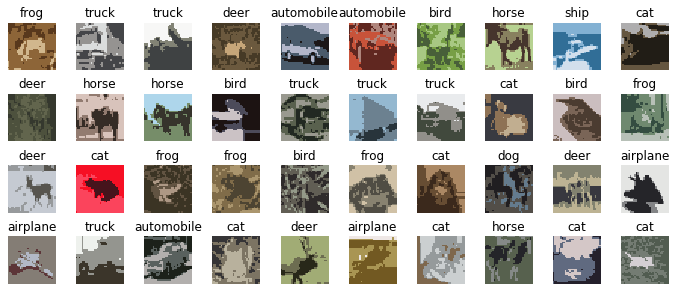

In [39]:
printImages(X_train_seg, y_train)

In [40]:
model_seg = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[32, 32, 3]),
    keras.layers.Dense(1000, activation="relu"),
    keras.layers.Dense(500, activation="relu"),
    keras.layers.Dense(250, activation="relu"),
    keras.layers.Dense(75, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [41]:
model_seg.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [42]:
history_seg = model_seg.fit(X_train_seg, y_train, epochs=30,
                    validation_data=(X_test_seg, y_test))

Train on 2000 samples, validate on 500 samples
Epoch 1/30
2000/2000 [==============================] - 1s 499us/sample - loss: 2.2512 - accuracy: 0.1685 - val_loss: 2.2234 - val_accuracy: 0.1420
Epoch 2/30
2000/2000 [==============================] - 0s 196us/sample - loss: 2.1465 - accuracy: 0.2140 - val_loss: 2.1692 - val_accuracy: 0.1720
Epoch 3/30
2000/2000 [==============================] - 0s 192us/sample - loss: 2.0738 - accuracy: 0.2700 - val_loss: 2.1098 - val_accuracy: 0.2060
Epoch 4/30
2000/2000 [==============================] - 0s 192us/sample - loss: 2.0102 - accuracy: 0.2875 - val_loss: 2.0837 - val_accuracy: 0.2480
Epoch 5/30
2000/2000 [==============================] - 0s 193us/sample - loss: 1.9515 - accuracy: 0.3125 - val_loss: 2.1394 - val_accuracy: 0.2440
Epoch 6/30
2000/2000 [==============================] - 0s 191us/sample - loss: 1.9207 - accuracy: 0.3145 - val_loss: 2.0704 - val_accuracy: 0.3100
Epoch 7/30
2000/2000 [==============================] - 0s 224us/

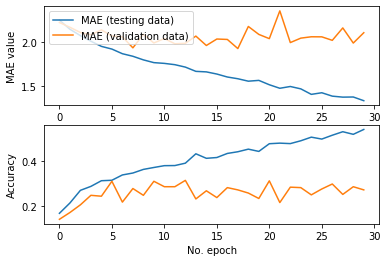

In [43]:
plotTrainingStat(history_seg)

In [44]:
import cv2

class CannyEdgeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    def fit(self, X):
        return self
    def transform(self, X):
        transformed_images = []
        for i in range(np.size(X, 0)):
            X[i] = X[i] * 255.0      
            canny_img = cv2.Canny(X[i].astype(np.uint8),32,32)
            canny_img = canny_img/255.0
            transformed_images.append(canny_img)
        return np.array(transformed_images)

In [45]:
canny_processing_pipeline = Pipeline([
    ('Canny', CannyEdgeTransformer()),
    ('Scaler', Scaler())
])

X_train_canny = canny_processing_pipeline.transform(X_train)
X_test_canny = canny_processing_pipeline.transform(X_test)

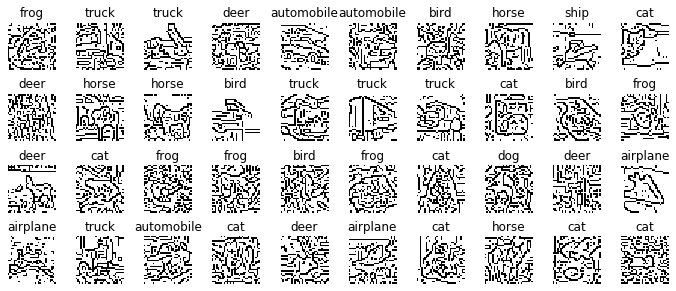

In [46]:
printImages(X_train_canny, y_train)

In [47]:
model_canny = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[32, 32]),
    keras.layers.Dense(1000, activation="relu"),
    keras.layers.Dense(500, activation="relu"),
    keras.layers.Dense(250, activation="relu"),
    keras.layers.Dense(75, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [48]:
model_canny.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [49]:
history_canny = model_canny.fit(X_train_canny, y_train, epochs=30,
                    validation_data=(X_test_canny, y_test))

Train on 2000 samples, validate on 500 samples
Epoch 1/30
2000/2000 [==============================] - 1s 488us/sample - loss: 2.3027 - accuracy: 0.0965 - val_loss: 2.3025 - val_accuracy: 0.1100
Epoch 2/30
2000/2000 [==============================] - 0s 172us/sample - loss: 2.3025 - accuracy: 0.1015 - val_loss: 2.3025 - val_accuracy: 0.0800
Epoch 3/30
2000/2000 [==============================] - 0s 164us/sample - loss: 2.3024 - accuracy: 0.1055 - val_loss: 2.3024 - val_accuracy: 0.0800
Epoch 4/30
2000/2000 [==============================] - 0s 159us/sample - loss: 2.3022 - accuracy: 0.1075 - val_loss: 2.3023 - val_accuracy: 0.0800
Epoch 5/30
2000/2000 [==============================] - 0s 164us/sample - loss: 2.3021 - accuracy: 0.1065 - val_loss: 2.3022 - val_accuracy: 0.0800
Epoch 6/30
2000/2000 [==============================] - 0s 171us/sample - loss: 2.3020 - accuracy: 0.1070 - val_loss: 2.3023 - val_accuracy: 0.0800
Epoch 7/30
2000/2000 [==============================] - 0s 179us/

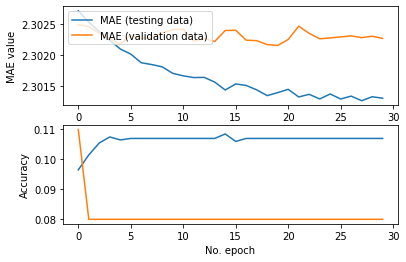

In [50]:
plotTrainingStat(history_canny)

In [51]:
img_processing_pipeline = Pipeline([
    ('Segmentation', ImageSegmentationTransformer(clusters=2)),
    ('CannyEdges', CannyEdgeTransformer())
])

X_train_final = img_processing_pipeline.transform(X_train)
X_test_final = img_processing_pipeline.transform(X_test)

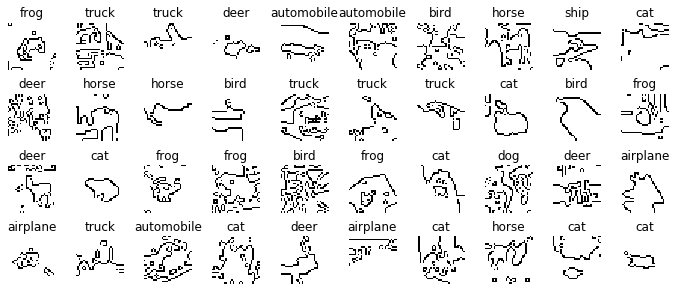

In [52]:
printImages(X_train_final, y_train)

In [53]:
model_final = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[32, 32]),
    keras.layers.Dense(1000, activation="relu"),
    keras.layers.Dense(500, activation="relu"),
    keras.layers.Dense(250, activation="relu"),
    keras.layers.Dense(75, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [54]:
model_final.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [55]:
history_final = model_final.fit(X_train_final, y_train, epochs=30,
                    validation_data=(X_test_final, y_test))

Train on 2000 samples, validate on 500 samples
Epoch 1/30
2000/2000 [==============================] - 1s 467us/sample - loss: 2.3111 - accuracy: 0.0970 - val_loss: 2.3063 - val_accuracy: 0.0940
Epoch 2/30
2000/2000 [==============================] - 0s 176us/sample - loss: 2.2866 - accuracy: 0.1330 - val_loss: 2.3038 - val_accuracy: 0.1040
Epoch 3/30
2000/2000 [==============================] - 0s 162us/sample - loss: 2.2666 - accuracy: 0.1690 - val_loss: 2.2996 - val_accuracy: 0.1100
Epoch 4/30
2000/2000 [==============================] - 0s 161us/sample - loss: 2.2463 - accuracy: 0.1950 - val_loss: 2.2945 - val_accuracy: 0.1160
Epoch 5/30
2000/2000 [==============================] - 0s 171us/sample - loss: 2.2245 - accuracy: 0.2415 - val_loss: 2.2894 - val_accuracy: 0.1360
Epoch 6/30
2000/2000 [==============================] - 0s 159us/sample - loss: 2.2010 - accuracy: 0.2820 - val_loss: 2.2855 - val_accuracy: 0.1440
Epoch 7/30
2000/2000 [==============================] - 0s 165us/

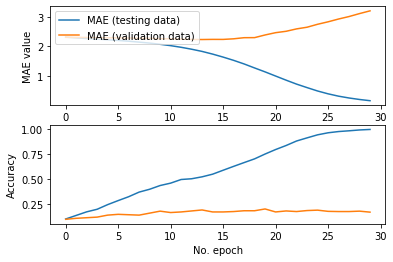

In [56]:
plotTrainingStat(history_final)